In [ ]:
# Installa le due librerie
!pip install pyspark
!pip install findspark

# Importa spark e findspark
import pyspark
import findspark
findspark.init()

# Definisce l'sqlContext
from pyspark.sql import SparkSession

sqlContext = SparkSession.builder.getOrCreate()

In [ ]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, NaiveBayes
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator

# Esempio di classificazione

Il dataset [Mushroom](https://archive.ics.uci.edu/ml/datasets/mushroom) contiene informazioni su diverse specie di funghi (e.s. il colore del gambo, del cappello, etc.) e per ogni specie viene indicato se è edibile (e) o se è velenosa (p).

L'obiettivo è allenare un classificatore per predire se fornite le varie caratteristiche un fungo è edibile o è velenoso.

Come prima cosa carichiamo i dati contenuti nel file *agaricus-lepiota.data* in un dataframe.
Il file non ha l'header, ma contiene solo i dati.

In [ ]:
df = sqlContext.read.option("header", False).csv("agaricus-lepiota.data")

Visualizziamo alcuni record.

La label da predire è nella colonna *_c0*

In [ ]:
df.show(10)

+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+
|_c0|_c1|_c2|_c3|_c4|_c5|_c6|_c7|_c8|_c9|_c10|_c11|_c12|_c13|_c14|_c15|_c16|_c17|_c18|_c19|_c20|_c21|_c22|
+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+
|  p|  x|  s|  n|  t|  p|  f|  c|  n|  k|   e|   e|   s|   s|   w|   w|   p|   w|   o|   p|   k|   s|   u|
|  e|  x|  s|  y|  t|  a|  f|  c|  b|  k|   e|   c|   s|   s|   w|   w|   p|   w|   o|   p|   n|   n|   g|
|  e|  b|  s|  w|  t|  l|  f|  c|  b|  n|   e|   c|   s|   s|   w|   w|   p|   w|   o|   p|   n|   n|   m|
|  p|  x|  y|  w|  t|  p|  f|  c|  n|  n|   e|   e|   s|   s|   w|   w|   p|   w|   o|   p|   k|   s|   u|
|  e|  x|  s|  g|  f|  n|  f|  w|  b|  k|   t|   e|   s|   s|   w|   w|   p|   w|   o|   e|   n|   a|   g|
|  e|  x|  y|  y|  t|  a|  f|  c|  b|  n|   e|   c|   s|   s|   w|   w|   p|   w|   o|   p|   k|   n|   g|
|  e|  b|  s|  w|  t|  a|  f|  c|  b|

Come si può notare le feature sono tutte testuali, è necessario convertirle in feature numeriche per poter utilizzare un classificatore.
Bisognerà trasformare ogni colonna utilizzando, ad esempio, il transformer StringIndexer fornito da Spark.

StringIndexer prende in ingresso una colonna e associa un id univoco ad ogni valore distinto, bisogna definire un indexer per ogni colonna che si vuole trasformare.

La colonna 0 è la label che indica se un fungo è commestibile (e) o velenoso (p), per questa colonna non usare lo StringIndexer, ma definire una funzione <i>udf</i> che associa un valore 0 se il valore è 'e' ed 1 se il valore è 'p'.

In [ ]:
# Definisce un indexer per ogni colonna del dataframe eccetto _c0 che è la label
indexers = [StringIndexer(inputCol=column, outputCol=column+"t").fit(df) for column in list(set(df.columns)-set(['_c0'])) ]

In [ ]:
# Crea una pipeline con tutti gli indexer
pipeline = Pipeline(stages=indexers)
# Genera i nomi delle colonne dopo averle trasformate
featureColumns = [c+"t" for c in list(set(df.columns)-set(['_c0']))]
# Definisce una udf per trasformare la colonna delle label
conv = udf(lambda t: 0 if t == 'e' else 1, IntegerType())
# Applica la trasformazione e seleziona solo le nuove colonne più la label convertita
df_r = pipeline.fit(df).transform(df).select(featureColumns+[conv("_c0").alias("label")])
df_r.show(10)

+----+-----+-----+----+----+-----+-----+-----+----+-----+----+-----+----+-----+----+-----+-----+----+-----+----+-----+-----+-----+
|_c6t|_c11t|_c16t|_c8t|_c7t|_c15t|_c17t|_c10t|_c1t|_c22t|_c2t|_c13t|_c3t|_c18t|_c4t|_c12t|_c19t|_c9t|_c21t|_c5t|_c20t|_c14t|label|
+----+-----+-----+----+----+-----+-----+-----+----+-----+----+-----+----+-----+----+-----+-----+----+-----+----+-----+-----+-----+
| 0.0|  2.0|  0.0| 1.0| 0.0|  0.0|  0.0|  1.0| 0.0|  4.0| 1.0|  0.0| 0.0|  0.0| 1.0|  0.0|  0.0| 7.0|  2.0| 6.0|  2.0|  0.0|    1|
| 0.0|  3.0|  0.0| 0.0| 0.0|  0.0|  0.0|  1.0| 0.0|  1.0| 1.0|  0.0| 3.0|  0.0| 1.0|  0.0|  0.0| 7.0|  3.0| 4.0|  1.0|  0.0|    0|
| 0.0|  3.0|  0.0| 0.0| 0.0|  0.0|  0.0|  1.0| 3.0|  5.0| 1.0|  0.0| 4.0|  0.0| 1.0|  0.0|  0.0| 3.0|  3.0| 5.0|  1.0|  0.0|    0|
| 0.0|  2.0|  0.0| 1.0| 0.0|  0.0|  0.0|  1.0| 0.0|  4.0| 0.0|  0.0| 4.0|  0.0| 1.0|  0.0|  0.0| 3.0|  2.0| 6.0|  2.0|  0.0|    1|
| 0.0|  2.0|  0.0| 0.0| 1.0|  0.0|  0.0|  0.0| 0.0|  1.0| 1.0|  0.0| 1.0|  0.0| 0.0

Ora che si sono convertiti i valori in numerici, bisogna definire la pipeline per eseguire il training del classificatore. <br/>
Il primo step della pipeline è la creazione delle feature, definire quindi un [VectorAssembler](https://spark.apache.org/docs/latest/ml-features.html#vectorassembler) che prende in ingresso le singole feature e le unisce in un vettore.

In [ ]:
vectorizer = VectorAssembler(inputCols=featureColumns, outputCol="features")

Adesso possiao definire il classificatore, utilizziamo un [DecisionTreeClassifier](https://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier). &Egrave; possibile visualizzare tutti i parametri del classificatore utilizzando il metodo <i>explainParams()</i>

In [ ]:
classifier = DecisionTreeClassifier()
print(classifier.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins for discretizing continuous features.  Must be 

Adesso si può definire la [pipeline](https://spark.apache.org/docs/latest/ml-pipeline.html) mettendo come primo stage la creazione delle feature, e come secondo stage il classificatore

In [ ]:
classificationPipeline = Pipeline().setStages([vectorizer, classifier])

Adesso bisogna suddividere i dati di ingresso in train e test. I dati di train verranno utilizzati per allenare il classificatore, mentre i dati di test per verificarne le performance.<br />
Per suddividere i dati utilizzare il metodo [randomSplit](https://spark.apache.org/docs/latest/ml-tuning.html#train-validation-split). In genere si utilizzano il 20% dei dati per il test e l'80% per il train.

In [ ]:
seed = 1234
(testDF, trainDF) = df_r.randomSplit([0.2, 0.8], seed)

Ora si può eseguire il train del classificatore, ottenendo così un modello allenato.

In [ ]:
model = classificationPipeline.fit(trainDF)

Adesso si può utilizzare il modello per eseguire una predizione sui dati di test

In [ ]:
predictions = model.transform(testDF)

Si possono visualizzare alcuni predizioni

In [ ]:
predictions.show(10)

+----+-----+-----+----+----+-----+-----+-----+----+-----+----+-----+----+-----+----+-----+-----+----+-----+----+-----+-----+-----+--------------------+-------------+--------------------+----------+
|_c6t|_c11t|_c16t|_c8t|_c7t|_c15t|_c17t|_c10t|_c1t|_c22t|_c2t|_c13t|_c3t|_c18t|_c4t|_c12t|_c19t|_c9t|_c21t|_c5t|_c20t|_c14t|label|            features|rawPrediction|         probability|prediction|
+----+-----+-----+----+----+-----+-----+-----+----+-----+----+-----+----+-----+----+-----+-----+----+-----+----+-----+-----+-----+--------------------+-------------+--------------------+----------+
| 0.0|  0.0|  0.0| 0.0| 0.0|  0.0|  0.0|  0.0| 0.0|  0.0| 0.0|  0.0| 0.0|  0.0| 1.0|  0.0|  0.0| 2.0|  0.0| 0.0|  1.0|  2.0|    0|(22,[14,17,20,21]...|[3333.0,22.0]|[0.99344262295081...|       0.0|
| 0.0|  0.0|  0.0| 0.0| 0.0|  0.0|  0.0|  0.0| 0.0|  0.0| 0.0|  0.0| 0.0|  0.0| 1.0|  0.0|  0.0| 2.0|  0.0| 0.0|  2.0|  1.0|    0|(22,[14,17,20,21]...|[3333.0,22.0]|[0.99344262295081...|       0.0|
| 0.0|  0.

Visto che il classificatore è binario (vi sono solo due classi: edibile o velenoso), è possibile utilizzare lo stimatore BinaryClassificationEvaluator per valutare le performance del modello

In [ ]:
estimator = BinaryClassificationEvaluator()
print(estimator.explainParams())

labelCol: label column name. (default: label)
metricName: metric name in evaluation (areaUnderROC|areaUnderPR) (default: areaUnderROC)
numBins: Number of bins to down-sample the curves (ROC curve, PR curve) in area computation. If 0, no down-sampling will occur. Must be >= 0. (default: 1000)
rawPredictionCol: raw prediction (a.k.a. confidence) column name. (default: rawPrediction)
weightCol: weight column name. If this is not set or empty, we treat all instance weights as 1.0. (undefined)


Lo stimatore fornisce come output l'accuracy del modello.

In [ ]:
print("Accuracy: "+str(estimator.evaluate(predictions)))

Accuracy: 0.9911504424778761


Possiamo vedere altre metriche usando la classe MulticlassMetrics.

In fase di inizializzazine si aspetta un RDD di tuple (predizione, label) dove sia predizione che label devono essere di tipo float.

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

In [ ]:
predizioni = predictions.select("prediction", "label").rdd.map(lambda x: (float(x[0]), float(x[1])))

mm = MulticlassMetrics(predizioni)

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Possiamo visualizzare la confusion matrix.

L'ordine delle label è in base al loro ordinamento crescente.
Avevamo definito:
- 0 -> edibile
- 1-> velenoso

<Axes: >

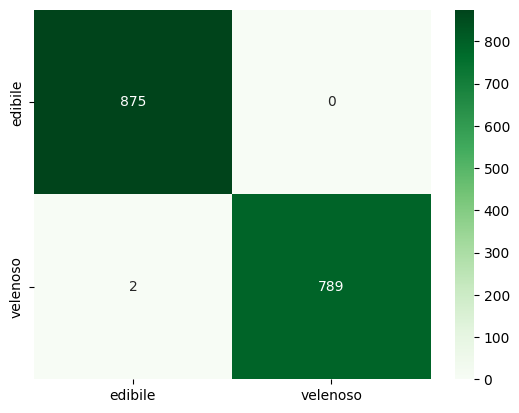

In [ ]:
import seaborn as sns
sns.heatmap(mm.confusionMatrix().toArray(), cmap="Greens", annot=True, fmt=".0f", xticklabels=['edibile', 'velenoso'], yticklabels=['edibile', 'velenoso'])

Possiamo vedere precision e recall su una specifica classe.

In [ ]:
print(f"Il {mm.recall(0.0)*100}% dei funghi edibili sono classificati correttamente")
print(f"Il {mm.precision(0.0)*100}% dei funghi classificati come edibili sono effettivamente edibili")
print()
print(f"Il {mm.recall(1.0)*100}% dei funghi velenosi sono classificati correttamente")
print(f"Il {mm.precision(1.0)*100}% dei funghi classificati come velenosi sono effettivamente velenosi")

Il 100.0% dei funghi edibili sono classificati correttamente
Il 99.77194982896236% dei funghi classificati come edibili sono effettivamente edibili

Il 99.74715549936789% dei funghi velenosi sono classificati correttamente
Il 100.0% dei funghi classificati come velenosi sono effettivamente velenosi


# Esempio di regressione
Il dataset [power plant](https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant) contiene i dati di produzione di una centrale elettrica. In particolare i dati contenuti sono:
* Temperatura (T) in °C
* Pressione ambientale (AP) in millibar
* Umidità relativa (RH) in %
* Volume gas esausti (V) in cmHg
* Produzione oraria di corrente (PE) in MW

L'obiettivo è creare un modello che dati in ingresso [T, AP, RH, V] stimi la quantità di corrente prodotta EP.

Come prima cosa caricare i dati contenuti nel file *Folds5x2_pp.xlsx*.


Potremmo usare l'API di Pandas on Spark, il problema è che su Google drive è presente una versione vecchia di Spark che crea problemi con le versioni installate di Numpy e Pandas che sono più recenti.

Carichiamo i dati con Pandas, poi convertiamo il dataframe in un dataframe di Spark, questo perché Spark non ha un connettore nativo per i file Excel.

In [ ]:
import pandas as pd

In [ ]:
# I file sono divisi in più fogli, impostando sheet_name=None vengono caricati
# tutti in un array di dataframe.
# con concat si possono unire.
df = pd.concat(pd.read_excel("Folds5x2_pp.xlsx", sheet_name=None)).reset_index()
df.drop(['level_0', 'level_1'], axis=1, inplace=True)

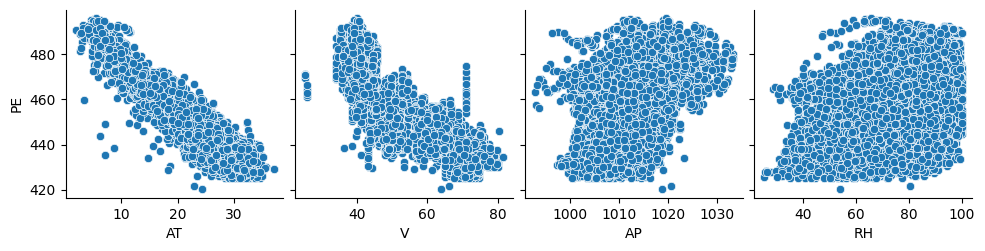

In [ ]:
# Già che abbiamo il dataframe di pandas possiamo vedere graficamente la dipendenza tra le varie variabili e la potenza erogata
sns.pairplot(df, y_vars=["PE"], x_vars=["AT", "V", "AP", "RH"])

In [ ]:
# Infine si può convertire il dataframe di Pandas in uno di Spark
df = sqlContext.createDataFrame(df)
df.show(5)

+-----+-----+-------+-----+------+
|   AT|    V|     AP|   RH|    PE|
+-----+-----+-------+-----+------+
|14.96|41.76|1024.07|73.17|463.26|
|25.18|62.96|1020.04|59.08|444.37|
| 5.11| 39.4|1012.16|92.14|488.56|
|20.86|57.32|1010.24|76.64|446.48|
|10.82| 37.5|1009.23|96.62| 473.9|
+-----+-----+-------+-----+------+
only showing top 5 rows



Creaiamo la pipeline per il training del modello. Anche in questo caso bisognerà creare il feature vector e scegliere un modello, useremo la [LinearRegression](https://spark.apache.org/docs/latest/ml-classification-regression.html#linear-regression)

In [ ]:
featureColumns = ['AT', 'V', 'AP', 'RH']
vectorizer = VectorAssembler(inputCols=featureColumns, outputCol="features")
linearRegression = LinearRegression(maxIter=100, regParam=0.1, labelCol='PE')
lrPipeline = Pipeline().setStages([vectorizer, linearRegression])

Creare i dataset di train e test

In [ ]:
seed = 1234
(testDF, trainDF) = df.randomSplit([0.2, 0.8], seed)

Alleniamo il modello con i dati di train

In [ ]:
model = lrPipeline.fit(trainDF)

Adesso si possono eseguire le predizioni con il modello allenato e valutare i risultati. Per valutare una regressione si utilizza lo stimatore RegressionEvaluator.
Lo stimatore può fornire varie misure, di base viene mostrato l'errore quadratico medio tra i valore predetti e quelli reali.

In [ ]:
predictions = model.transform(testDF)
predictions.show(10)

+----+-----+-------+-----+------+--------------------+------------------+
|  AT|    V|     AP|   RH|    PE|            features|        prediction|
+----+-----+-------+-----+------+--------------------+------------------+
| 3.0|39.64| 1011.0|80.14| 485.2|[3.0,39.64,1011.0...| 488.8511440520558|
| 3.2|41.31| 997.67|98.84|489.86|[3.2,41.31,997.67...|484.26561230157677|
|3.38|39.64| 1011.0|81.22|488.92|[3.38,39.64,1011....| 487.9629976415614|
| 3.4|39.64| 1011.1|83.43|459.86|[3.4,39.64,1011.1...|487.60467416714494|
|3.51|35.47|1017.53|86.56|489.07|[3.51,35.47,1017....| 488.4858039522743|
| 3.6|35.19|1018.73| 99.1|488.98|[3.6,35.19,1018.7...|486.61714914188747|
|3.69|38.44|1016.74|82.87|490.78|[3.69,38.44,1016....| 487.8644194164567|
|3.74|35.19|1018.58|98.84| 490.5|[3.74,35.19,1018....| 486.3761662165842|
|3.82|35.47|1016.62|84.34|489.04|[3.82,35.47,1016....|488.15246411735245|
|3.91|35.47|1016.92|86.03|488.67|[3.91,35.47,1016....| 487.7521061777033|
+----+-----+-------+-----+------+-----

In [ ]:
estimatorRmse = RegressionEvaluator(labelCol='PE', metricName='rmse')
print("RMSE: "+str(estimatorRmse.evaluate(predictions)))

estimatorR2 = RegressionEvaluator(labelCol='PE', metricName='r2')
print("R2 "+str(estimatorR2.evaluate(predictions)))

RMSE: 4.459356977563864
R2 0.9321024615430726
